Found 400 images belonging to 5 classes.
Found 100 images belonging to 5 classes.

Training samples: 400
Validation samples: 100
Classes: {'Mild': 0, 'Moderate': 1, 'NO Dr': 2, 'Proliferative_DR': 3, 'Severe Dr': 4}

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


100/100 ━━━━━━━━━━━━━━━━━━━━ 23s 105ms/step - accuracy: 0.1747 - loss: 2.1068 - val_accuracy: 0.2100 - val_loss: 1.6105 - learning_rate: 3.0000e-05
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 452us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 3.0000e-05
Epoch 3/50


/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)
/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:206: UserWarning: Can save best model only with val_accuracy available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)
/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/callback_list.py:96: UserWarning: Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss,lea

100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.1758 - loss: 1.7747 - val_accuracy: 0.2000 - val_loss: 1.6025 - learning_rate: 3.0000e-05
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 3.0000e-05
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - accuracy: 0.2326 - loss: 1.7555 - val_accuracy: 0.3100 - val_loss: 1.5639 - learning_rate: 3.0000e-05
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 3.0000e-05
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - accuracy: 0.2354 - loss: 1.7537 - val_accuracy: 0.4700 - val_loss: 1.5511 - learning_rate: 3.0000e-05
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 230us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 3.0000e-05
Epoch 9/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.2177 - loss: 1.7608 - val_accuracy: 0.3600 - val_loss: 1.5384 - learning_rate: 3.0000e-05
Epoch 10/50

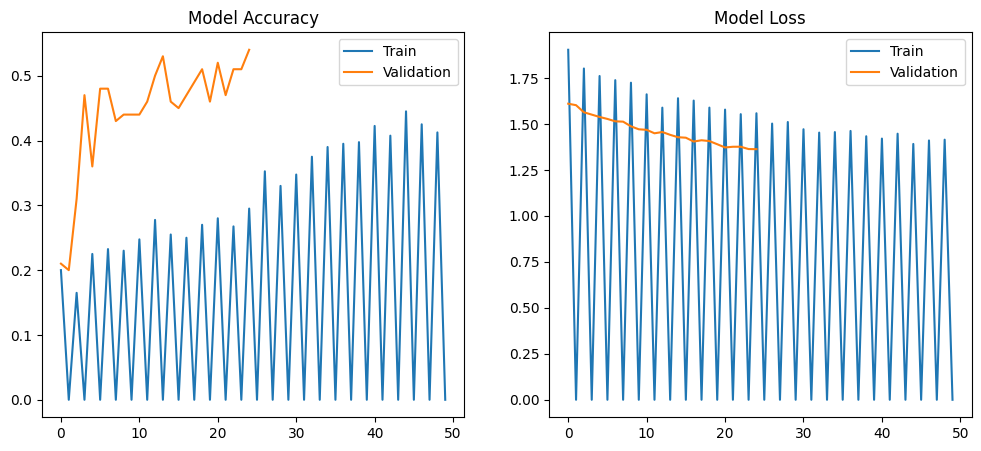

In [11]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import numpy as np
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# 1. Environment Setup - Must be first!
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Suppress most logs

# Set memory growth BEFORE any other TF operations
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print("Warning: Could not set memory growth. Continuing anyway...")

# 2. Configuration for Small Datasets
config = {
    'data_dir': '/kaggle/input/local-preprocessed-dataset/LOCAL PREPROCESSED DATASET',
    'batch_size': 4,  # Very small batch size
    'img_size': (224, 224),
    'epochs': 50,
    'learning_rate': 3e-5,
    'validation_split': 0.2,
    'seed': 42,
    'min_samples': 20
}

# 3. Data Pipeline
def create_data_generators():
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=10,
        width_shift_range=0.05,
        height_shift_range=0.05,
        horizontal_flip=True,
        validation_split=config['validation_split']
    )
    
    val_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=config['validation_split']
    )
    
    train_gen = train_datagen.flow_from_directory(
        config['data_dir'],
        target_size=config['img_size'],
        batch_size=config['batch_size'],
        class_mode='categorical',
        subset='training',
        shuffle=True,
        seed=config['seed']
    )
    
    val_gen = val_datagen.flow_from_directory(
        config['data_dir'],
        target_size=config['img_size'],
        batch_size=config['batch_size'],
        class_mode='categorical',
        subset='validation',
        shuffle=False,
        seed=config['seed']
    )
    
    if train_gen.samples < config['min_samples']:
        raise ValueError(f"Need at least {config['min_samples']} training samples per class")
    
    print(f"\nTraining samples: {train_gen.samples}")
    print(f"Validation samples: {val_gen.samples}")
    print(f"Classes: {train_gen.class_indices}\n")
    
    return train_gen, val_gen

# 4. Model Definition
def build_model(num_classes):
    base_model = ResNet50(
        weights='imagenet',
        include_top=False,
        input_shape=(*config['img_size'], 3),
        pooling='avg'
    )
    base_model.trainable = False
    
    model = models.Sequential([
        base_model,
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.4),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    model.compile(
        optimizer=optimizers.Adam(config['learning_rate']),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# 5. Training Process
def train_model():
    train_gen, val_gen = create_data_generators()
    model = build_model(len(train_gen.class_indices))
    
    # Callbacks
    callbacks_list = [
        callbacks.EarlyStopping(
            patience=15,
            monitor='val_accuracy',
            restore_best_weights=True
        ),
        callbacks.ModelCheckpoint(
            'best_model.keras',
            monitor='val_accuracy',
            save_best_only=True
        ),
        callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=1e-6
        )
    ]
    
    # Training
    history = model.fit(
        train_gen,
        steps_per_epoch=max(1, train_gen.samples // config['batch_size']),
        validation_data=val_gen,
        validation_steps=max(1, val_gen.samples // config['batch_size']),
        epochs=config['epochs'],
        callbacks=callbacks_list,
        verbose=1
    )
    return model, history, val_gen

# 6. Main Execution
if __name__ == "__main__":
    try:
        model, history, val_gen = train_model()
        
        # Evaluation
        val_gen.reset()
        y_pred = np.argmax(model.predict(val_gen), axis=1)
        
        print("\nClassification Report:")
        print(classification_report(
            val_gen.classes,
            y_pred,
            target_names=list(val_gen.class_indices.keys())
        ))
        
        # Plot results
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'], label='Train')
        plt.plot(history.history['val_accuracy'], label='Validation')
        plt.title('Model Accuracy')
        plt.legend()
        
        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'], label='Train')
        plt.plot(history.history['val_loss'], label='Validation')
        plt.title('Model Loss')
        plt.legend()
        plt.show()
        
    except Exception as e:
        print(f"\nError: {str(e)}")
        print("Recommended actions:")
        print("1. Verify directory structure exists")
        print("2. Check image files are valid")
        print("3. Try batch_size=2 if memory issues persist")
        print("4. Ensure minimum 20 images per class")

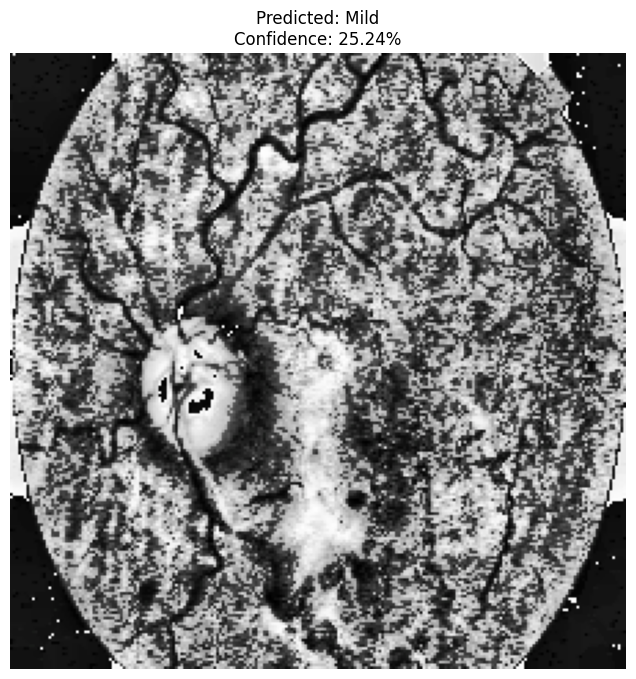


Final Prediction: Mild
Confidence: 25.24%
Batch prediction error: [Errno 20] Not a directory: '/kaggle/input/local-preprocessed-dataset/LOCAL PREPROCESSED DATASET/Severe Dr/166068a24416.png'


In [13]:
# ====== CORRECTED PREDICTION CELL ======

def predict_retinopathy_class(image_path, model, class_labels):
    """
    Predicts the retinopathy class for a single image
    Args:
        image_path: Path to the image file
        model: Trained Keras model
        class_labels: Dictionary mapping class indices to names
    Returns:
        pred_class: Predicted class name
        confidence: Prediction confidence percentage
        visualization: Displayed image with prediction
    """
    try:
        # Correct path handling for Kaggle
        if not os.path.exists(image_path):
            # Try alternative path format
            alt_path = os.path.join('/kaggle/input', *image_path.split('/')[3:])
            if not os.path.exists(alt_path):
                raise FileNotFoundError(f"Neither path exists: {image_path} or {alt_path}")
            image_path = alt_path
        
        # Load and preprocess image
        img = tf.keras.utils.load_img(
            image_path,
            target_size=config['img_size'],
            color_mode='rgb'
        )
        img_array = tf.keras.utils.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0) / 255.0
        
        # Make prediction
        pred = model.predict(img_array, verbose=0)
        pred_class = np.argmax(pred)
        confidence = np.max(pred) * 100
        class_name = class_labels[pred_class]
        
        # Display results
        plt.figure(figsize=(8, 8))
        plt.imshow(img)
        plt.title(f"Predicted: {class_name}\nConfidence: {confidence:.2f}%")
        plt.axis('off')
        plt.show()
        
        return class_name, confidence
    
    except Exception as e:
        print(f"Prediction error: {str(e)}")
        return None, None

# Example usage with proper Kaggle paths:
test_image_path = "/kaggle/input/local-preprocessed-dataset/LOCAL PREPROCESSED DATASET/Severe Dr/166068a24416.png"  # Absolute path
class_labels = {v: k for k, v in val_gen.class_indices.items()}  # Get class mapping

predicted_class, confidence = predict_retinopathy_class(
    test_image_path,
    model,
    class_labels
)

if predicted_class:
    print(f"\nFinal Prediction: {predicted_class}")
    print(f"Confidence: {confidence:.2f}%")
else:
    print("Prediction failed")

# ====== BATCH PREDICTION FUNCTION ======

def batch_predict(directory_path, model, class_labels):
    """
    Predicts classes for all images in a directory
    Args:
        directory_path: Path to directory containing images
        model: Trained Keras model
        class_labels: Dictionary mapping class indices to names
    """
    try:
        # Handle Kaggle paths
        if not os.path.exists(directory_path):
            alt_path = os.path.join('/kaggle/input', *directory_path.split('/')[3:])
            if not os.path.exists(alt_path):
                raise FileNotFoundError(f"Neither path exists: {directory_path} or {alt_path}")
            directory_path = alt_path
        
        # Create prediction generator
        pred_datagen = ImageDataGenerator(rescale=1./255)
        
        pred_gen = pred_datagen.flow_from_directory(
            directory_path,
            target_size=config['img_size'],
            batch_size=config['batch_size'],
            class_mode=None,  # No labels needed
            shuffle=False
        )
        
        # Get predictions
        predictions = model.predict(pred_gen, verbose=1)
        pred_classes = np.argmax(predictions, axis=1)
        
        # Map to class names
        pred_class_names = [class_labels[c] for c in pred_classes]
        
        # Print results
        print("\nBatch Prediction Results:")
        for i, (img_path, class_name) in enumerate(zip(pred_gen.filenames, pred_class_names)):
            confidence = np.max(predictions[i]) * 100
            print(f"{img_path}: {class_name} ({confidence:.2f}%)")
            
        return pred_class_names
        
    except Exception as e:
        print(f"Batch prediction error: {str(e)}")
        return None

# Example batch usage for Kaggle:
test_dir = "/kaggle/input/local-preprocessed-dataset/LOCAL PREPROCESSED DATASET/Severe Dr/166068a24416.png"
batch_results = batch_predict(test_dir, model, class_labels)